In [146]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

In [147]:
# Raw Data
# BBCA = yf.download('BBCA.JK', start='2004-06-08', end='2025-02-20')
BBCA = pd.read_csv('BBCA_JK.csv')
# BBCA = yf.Ticker("BBRI.JK")
# BBCA = BBCA.history(period="max")

BBCA.reset_index(inplace=True)
# BBCA['Date'] = BBCA['Date'].dt.date
BBCA['Date'] = pd.to_datetime(BBCA['Date'])
BBCA.reset_index(inplace=True)
BBCA

,level_0,index,Date,Close,High,Low,Open,Volume
0,0,0,2004-06-08,99.696129,101.100300,98.291958,98.291958,499150000
1,1,1,2004-06-09,101.100273,102.504444,98.291932,99.696103,294290000
2,2,2,2004-06-10,101.100273,101.100273,99.696103,101.100273,165590000
3,3,3,2004-06-11,101.100273,101.100273,99.696103,99.696103,135830000
4,4,4,2004-06-14,99.696129,101.100300,98.291958,101.100300,158540000
...,...,...,...,...,...,...,...,...
5169,5169,5169,2025-05-19,9500.000000,9500.000000,9250.000000,9275.000000,111597200
5170,5170,5170,2025-05-20,9475.000000,9675.000000,9475.000000,9500.000000,160614800
5171,5171,5171,2025-05-21,9700.000000,9725.000000,9550.000000,9700.000000,169739200
5172,5172,5172,2025-05-22,9650.000000,9800.000000,9650.000000,9800.000000,103113000


In [148]:
# BBCA.to_csv('BBCA_data.csv', index=False)

In [149]:
# Data di potong hingga sisa kolom Date dan Close
BBCA = BBCA[["Date", "Close"]]
BBCA

,Date,Close
0,2004-06-08,99.696129
1,2004-06-09,101.100273
2,2004-06-10,101.100273
3,2004-06-11,101.100273
4,2004-06-14,99.696129
...,...,...
5169,2025-05-19,9500.000000
5170,2025-05-20,9475.000000
5171,2025-05-21,9700.000000
5172,2025-05-22,9650.000000


0      2004-06-08
1      2004-06-09
2      2004-06-10
3      2004-06-11
4      2004-06-14
          ...    
5169   2025-05-19
5170   2025-05-20
5171   2025-05-21
5172   2025-05-22
5173   2025-05-23
Name: Date, Length: 5174, dtype: datetime64[ns]

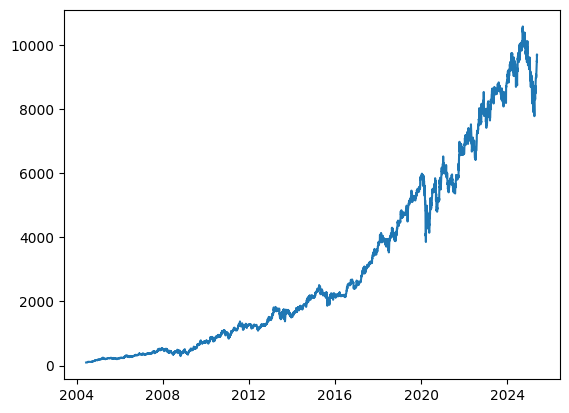

In [150]:
plt.plot(BBCA['Date'], BBCA['Close'])
BBCA['Date']

In [151]:
#mengubah str ke datetime
import datetime

def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

In [152]:
#ngubah data menjadi windowed df
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date
  
  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    if next_date == target_date:
      if next_date == target_date:
        print(f"Warning: next_date ({next_date}) sama dengan target_date ({target_date}), mencari tanggal berikutnya...")
      
      # Cari semua tanggal yang lebih besar dari target_date
      future_dates = dataframe.index[dataframe.index > target_date]
      
      if len(future_dates) > 0:
          next_date = future_dates[0]  # Ambil tanggal pertama yang lebih besar
      else:
          print(f"Tidak ada tanggal berikutnya setelah {target_date}, loop berhenti.")
          break
    
    if last_time:
      break
    
    target_date = next_date

    if target_date >= last_date:
      last_time = True
    
    print(next_week)
    
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]
  
  ret_df['Target'] = Y

  return ret_df


In [153]:
#masukkin data
#n = mau melihat berapa data kebelakang, karena ini LSTM
BBCA.index = BBCA.pop('Date')
start = '2004-06-11'
end = datetime.date.today().strftime('%Y-%m-%d')
windowed_df = df_to_windowed_df(BBCA, start , end, n=3)

                 Close
Date                  
2004-06-11  101.100273
2004-06-14   99.696129
2004-06-15  102.504410
2004-06-16  101.100273
2004-06-17   99.696129
2004-06-18   99.696129
                 Close
Date                  
2004-06-14   99.696129
2004-06-15  102.504410
2004-06-16  101.100273
2004-06-17   99.696129
2004-06-18   99.696129
2004-06-21   99.696129
                 Close
Date                  
2004-06-15  102.504410
2004-06-16  101.100273
2004-06-17   99.696129
2004-06-18   99.696129
2004-06-21   99.696129
2004-06-22   99.696129
                 Close
Date                  
2004-06-16  101.100273
2004-06-17   99.696129
2004-06-18   99.696129
2004-06-21   99.696129
2004-06-22   99.696129
2004-06-23  101.100273
                 Close
Date                  
2004-06-17   99.696129
2004-06-18   99.696129
2004-06-21   99.696129
2004-06-22   99.696129
2004-06-23  101.100273
2004-06-24  101.100273
                 Close
Date                  
2004-06-18   99.696129
2004-06-21 

In [154]:
#ngubah bentuk windowed DF menjadi tabel
# Date | X | Y
# X = data harga kebelakang sebelum hari tersebut
# y = harga di hari tersebut
# date = tanggal
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)
print(windowed_df)

dates.shape, X.shape, y.shape


     Target Date     Target-3     Target-2     Target-1       Target
0     2004-06-11    99.696129   101.100273   101.100273   101.100273
1     2004-06-14   101.100273   101.100273   101.100273    99.696129
2     2004-06-15   101.100273   101.100273    99.696129   102.504410
3     2004-06-16   101.100273    99.696129   102.504410   101.100273
4     2004-06-17    99.696129   102.504410   101.100273    99.696129
...          ...          ...          ...          ...          ...
5166  2025-05-19  9275.000000  9275.000000  9300.000000  9500.000000
5167  2025-05-20  9275.000000  9300.000000  9500.000000  9475.000000
5168  2025-05-21  9300.000000  9500.000000  9475.000000  9700.000000
5169  2025-05-22  9500.000000  9475.000000  9700.000000  9650.000000
5170  2025-05-23  9475.000000  9700.000000  9650.000000  9675.000000

[5171 rows x 5 columns]


((5171,), (5171, 3, 1), (5171,))

In [155]:
print(X)

[[[  99.69613]
  [ 101.10027]
  [ 101.10027]]

 [[ 101.10027]
  [ 101.10027]
  [ 101.10027]]

 [[ 101.10027]
  [ 101.10027]
  [  99.69613]]

 ...

 [[9300.     ]
  [9500.     ]
  [9475.     ]]

 [[9500.     ]
  [9475.     ]
  [9700.     ]]

 [[9475.     ]
  [9700.     ]
  [9650.     ]]]


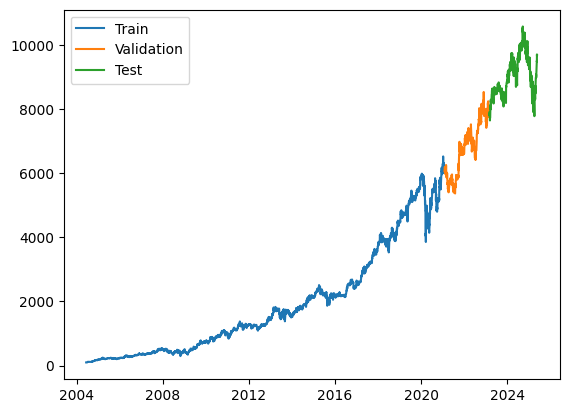

In [156]:
#membagi table

q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

samples, timesteps, features = X.shape
X_2D = X.reshape((samples, timesteps * features))
X_scaled_2D = scaler.fit_transform(X_2D)
X = X_scaled_2D.reshape((samples, timesteps, features))

y = y.reshape(-1, 1)
y = scaler.fit_transform(y)


dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

y_train_rescaled = scaler.inverse_transform(y_train.reshape(-1, 1)).flatten()
y_val_rescaled = scaler.inverse_transform(y_val.reshape(-1, 1)).flatten()
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

plt.plot(dates_train, y_train_rescaled)
plt.plot(dates_val, y_val_rescaled)
plt.plot(dates_test, y_test_rescaled)

plt.legend(['Train', 'Validation', 'Test'])

In [157]:
# Train model dengan LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError

# function untuk training dari awal
# # 3 karena kita make 3 target (maximal 3 hari kebelakang) (Array 3x1)
def build_model():
    model = Sequential([layers.Input((3, 1)),
                        layers.LSTM(64),
                        layers.Dense(32, activation='relu'),
                        layers.Dense(32, activation='relu'),
                        layers.Dense(1)])

    model.compile(loss=MeanSquaredError(), 
                optimizer=Adam(learning_rate=0.001),
                metrics=['mean_absolute_error'])

    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)
    model.save("model_lstm_v3.h5")
    return model

# function untuk load model
model = load_model('model_lstm_v3.h5')

130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


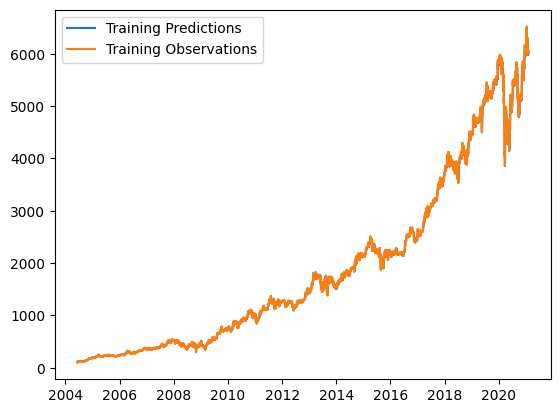

In [158]:
# Predict dulu
train_predictions = model.predict(X_train).flatten()

# Inverse transform predictions
train_predictions_rescaled = scaler.inverse_transform(train_predictions.reshape(-1, 1)).flatten()

# Inverse transform y_train
y_train_rescaled = scaler.inverse_transform(y_train.reshape(-1, 1)).flatten()

# Baru plotting
plt.plot(dates_train, train_predictions_rescaled)
plt.plot(dates_train, y_train_rescaled)
plt.legend(['Training Predictions', 'Training Observations'])

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


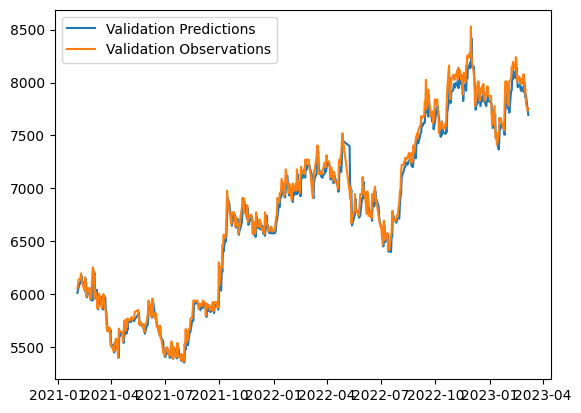

In [159]:
val_predictions = model.predict(X_val).flatten()

# Inverse transform predictions
val_predictions_rescaled = scaler.inverse_transform(val_predictions.reshape(-1, 1)).flatten()

# Inverse transform y_train
y_val_rescaled = scaler.inverse_transform(y_val.reshape(-1, 1)).flatten()

# Baru plotting
plt.plot(dates_val, val_predictions_rescaled)
plt.plot(dates_val, y_val_rescaled)
plt.legend(['Validation Predictions', 'Validation Observations'])

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


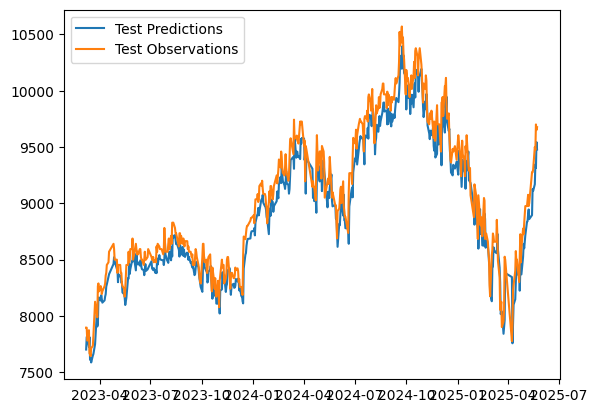

In [160]:
test_predictions = model.predict(X_test).flatten()

# Inverse transform predictions
test_predictions_rescaled = scaler.inverse_transform(test_predictions.reshape(-1, 1)).flatten()

# Inverse transform y_train
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Baru plotting
plt.plot(dates_test, test_predictions_rescaled)
plt.plot(dates_test, y_test_rescaled)
plt.legend(['Test Predictions', 'Test Observations'])

In [161]:
def plot_predictions(dates_train, train_predictions, y_train,
                        dates_val, val_predictions, y_val,
                        dates_test, test_predictions, y_test):
    train_predictions_rescaled = scaler.inverse_transform(train_predictions.reshape(-1, 1)).flatten()
    y_train_rescaled = scaler.inverse_transform(y_train.reshape(-1, 1)).flatten()

    val_predictions_rescaled = scaler.inverse_transform(val_predictions.reshape(-1, 1)).flatten()
    y_val_rescaled = scaler.inverse_transform(y_val.reshape(-1, 1)).flatten()

    test_predictions_rescaled = scaler.inverse_transform(test_predictions.reshape(-1, 1)).flatten()
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
    plt.plot(dates_train, train_predictions_rescaled)
    plt.plot(dates_train, y_train_rescaled)
    plt.plot(dates_val, val_predictions_rescaled)
    plt.plot(dates_val, y_val_rescaled)
    plt.plot(dates_test, test_predictions_rescaled)
    plt.plot(dates_test, y_test_rescaled)
    plt.legend(['Predicted_train', 
                'Actual_train',
                'Predicted_validation', 
                'Actual_validation',
                'Predicted_test', 
                'Actual_testing'])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
[7720.04]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
[7669.2583]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
[7620.4204]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
[7573.453]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
[7528.284]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
[7484.845]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
[7443.072]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
[7402.8984]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
[7364.2646]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
[7327.112]
maximum from predict :  [7720.04] date :  2025-05-24
minimum from predict :  [7327.112] date :  2025-06-02


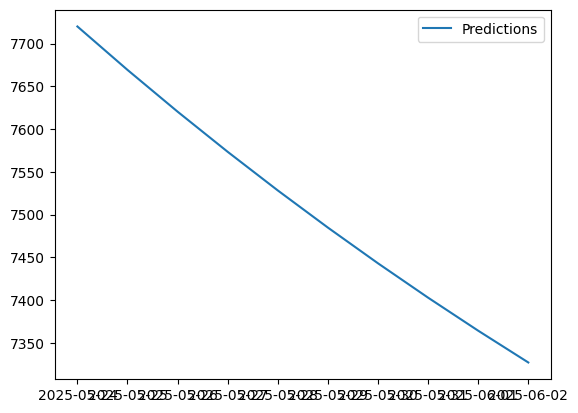

In [169]:
X_last = X[-1]
X_last = X_last.reshape(1, X_last.shape[0], X_last.shape[1])
test_res = []
curr_date = dates[-1]
day_pred = []
day = int(input("berapa hari yang ingin di prediksi : "))
for i in range(day):
    test_predictions = model.predict(X_last).flatten()
    X_last[0][0] = X_last[0][1]
    X_last[0][1] = X_last[0][2]
    X_last[0][2] = test_predictions

    now_date = curr_date + datetime.timedelta(days=1)
    append_date = (curr_date + datetime.timedelta(days=1)).date()
    curr_date = now_date
    day_pred.append(append_date)
    
    # Inverse transform predictions
    test_predictions_rescaled = scaler.inverse_transform(test_predictions.reshape(-1, 1)).flatten()

    # Inverse transform y_train
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

    test_res.append(test_predictions_rescaled)
    print(test_predictions_rescaled)

print("maximum from predict : ",max(test_res), "date : ",day_pred[test_res.index(max(test_res))])
print("minimum from predict : ",min(test_res), "date : ",day_pred[test_res.index(min(test_res))])

def plot_future_predictions(day_pred, test_res):
    plt.plot(day_pred, test_res)
    plt.legend(['Predictions'])
    plt.show()

plot_future_predictions(day_pred, test_res)
#cari min, max dari saham yang sudah di predict

In [163]:
predictions = model.predict(X).flatten()

162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [164]:
y_test_asli = scaler.inverse_transform(y_test)
predicted_asli = scaler.inverse_transform(predictions.reshape(-1, 1))

y_asli = scaler.inverse_transform(y)

In [165]:
#hitung akurasi menggunakan MSE
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_asli, predicted_asli)
print("MSE dari model ini adalah : ",mse)

#hitung akurasi menggunakan MAE
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_asli, predicted_asli)
print("MAE dari model ini adalah : ",mae)

#hitung akurasi menggunakan RMSE
from sklearn.metrics import r2_score
r2 = r2_score(y_asli, predicted_asli)
print(f'R-squared (R²): {r2}')

MSE dari model ini adalah :  5819.25048828125
MAE dari model ini adalah :  40.00220489501953
R-squared (R²): 0.9993044137954712


In [166]:
def train_eval_lstm_fold(X, y, n_splits=5, epochs=10, batch_size=32):
    kf = KFold(n_splits=n_splits, shuffle=False)  # Untuk time series, jaga urutan
    rmse_list = []
    mae_list = []

    fold = 1
    for train_idx, val_idx in kf.split(X):
        print(f"Fold {fold}")
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        model = build_model()
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

        preds = model.predict(X_val).flatten()
        rmse = np.sqrt(mean_squared_error(y_val, preds))
        mae = mean_absolute_error(y_val, preds)

        print(f"RMSE: {rmse}, MAE: {mae}")
        rmse_list.append(rmse)
        mae_list.append(mae)
        fold += 1

    print("Cross-validated RMSE:", rmse_list)
    print("Mean RMSE:", np.mean(rmse_list))
    print("Cross-validated MAE:", mae_list)
    print("Mean MAE:", np.mean(mae_list))
# train_eval_lstm_fold(X, y, n_splits=5, epochs=20)